In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots
import folium 
from folium import plugins
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt


from pathlib import Path
data_dir = Path('/content/drive/MyDrive/covid_2')

import os
os.listdir(data_dir)

import warnings
warnings.filterwarnings('ignore')

In [3]:
cleaned_data = pd.read_csv(data_dir/'cleaned_data.csv',parse_dates=['Date'])


In [4]:
grouped_us = cleaned_data[cleaned_data['Country/Region'] == "US"].reset_index()
grouped_us_date = grouped_us.groupby('Date')['Date', 'Confirmed', 'Deaths','Recovered','Active'].sum().reset_index()

grouped_UK = cleaned_data[cleaned_data['Country/Region'] == "United Kingdom"].reset_index()
grouped_UK_date = grouped_UK.groupby('Date')['Date', 'Confirmed', 'Deaths','Recovered','Active'].sum().reset_index()

grouped_Brazil = cleaned_data[cleaned_data['Country/Region'] == "Brazil"].reset_index()
grouped_Brazil_date = grouped_Brazil.groupby('Date')['Date', 'Confirmed', 'Deaths','Recovered','Active'].sum().reset_index()

grouped_Russia = cleaned_data[cleaned_data['Country/Region'] == "Russia"].reset_index()
grouped_Russia_date = grouped_Russia.groupby('Date')['Date', 'Confirmed', 'Deaths','Recovered','Active'].sum().reset_index()

grouped_India = cleaned_data[cleaned_data['Country/Region'] == "India"].reset_index()
grouped_India_date = grouped_India.groupby('Date')['Date', 'Confirmed', 'Deaths','Recovered','Active'].sum().reset_index()

grouped_rest = cleaned_data[~cleaned_data['Country/Region'].isin(['US', 'United Kingdom', 'Brazil', 'Russia', 'India'])].reset_index()
grouped_rest_date = grouped_rest.groupby('Date')['Date', 'Confirmed', 'Deaths','Recovered','Active'].sum().reset_index()

# Modeling <a id="3"></a>

Now, I will demonstrate how sales can be forecasted using various methods, namely: **naive approach, moving average, Holt linear, exponential smoothing, ARIMA, and Prophet**

## Train/Val split <a id="3.1"></a>

First, we need to create miniature training and validation sets to train and validate our models. I will take the last 90 days as the validation data and the 300 days before that as the training data. We need to predict the sales in the validation data using the sales in the training data.

In [5]:
train_dataset = pd.read_csv('/content/drive/MyDrive/covid_2/time_series_covid_19_confirmed.csv')
drop_clo = ['Province/State','Country/Region','Lat','Long']
train_dataset=train_dataset.drop(drop_clo,axis=1)
datewise= list(train_dataset.columns)
val_dataset = train_dataset[datewise[-30:]]

In [6]:
train_dataset.drop(columns = train_dataset.columns[:100], axis = 1, inplace = True)
train_dataset

,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,2291,2470,2705,2895,3225,3393,3564,3781,4042,4403,...,64575,65080,65486,65728,66275,66903,67743,68366,69130,70111
1,782,789,795,803,820,832,842,850,856,868,...,132118,132153,132176,132209,132215,132229,132244,132264,132285,132297
2,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,...,126156,126434,126651,126860,127107,127361,127646,127926,128198,128456
3,745,747,748,750,751,751,752,752,754,755,...,13569,13569,13569,13569,13569,13664,13671,13682,13693,13693
4,30,35,35,35,36,36,36,43,43,45,...,31661,31909,32149,32441,32623,32933,33338,33607,33944,34180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,270,270,271,271,271,271,288,288,288,288,...,4809,4941,5119,5275,5404,5931,6086,6356,6396,6908
272,353,353,353,362,371,374,375,375,375,375,...,304532,304968,305201,305201,305777,306334,306795,306795,307569,307838
273,7,10,10,12,21,25,25,34,34,51,...,6613,6632,6649,6658,6662,6670,6688,6696,6723,6731
274,109,119,124,137,138,146,153,167,252,267,...,92754,92920,93106,93201,93279,93428,93627,93947,94430,94751


In [7]:
pip install -U kaleido


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.8 MB/s eta 0:00:00


In [8]:

pip install plotly kaleido IPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.3 MB/s eta 0:00:00


In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

* Below are the sales from three sample data points. I will use these samples to demonstrate the working of the models.

**now we will see the Forcasting of all the important attribute like <font size=4 style="color:red"> Confirmed</font>,<font size=4 style="color:red"> Deaths</font>,<font size=4 style="color:red"> Recovered</font> **

# time_series_covid_19_confirmed

**lets see the sample data points**

In [10]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines+markers', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"), showlegend=False,),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines+markers', marker=dict(color="darkorange"), showlegend=False,),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines+markers', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines+markers', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines+markers', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines+markers', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

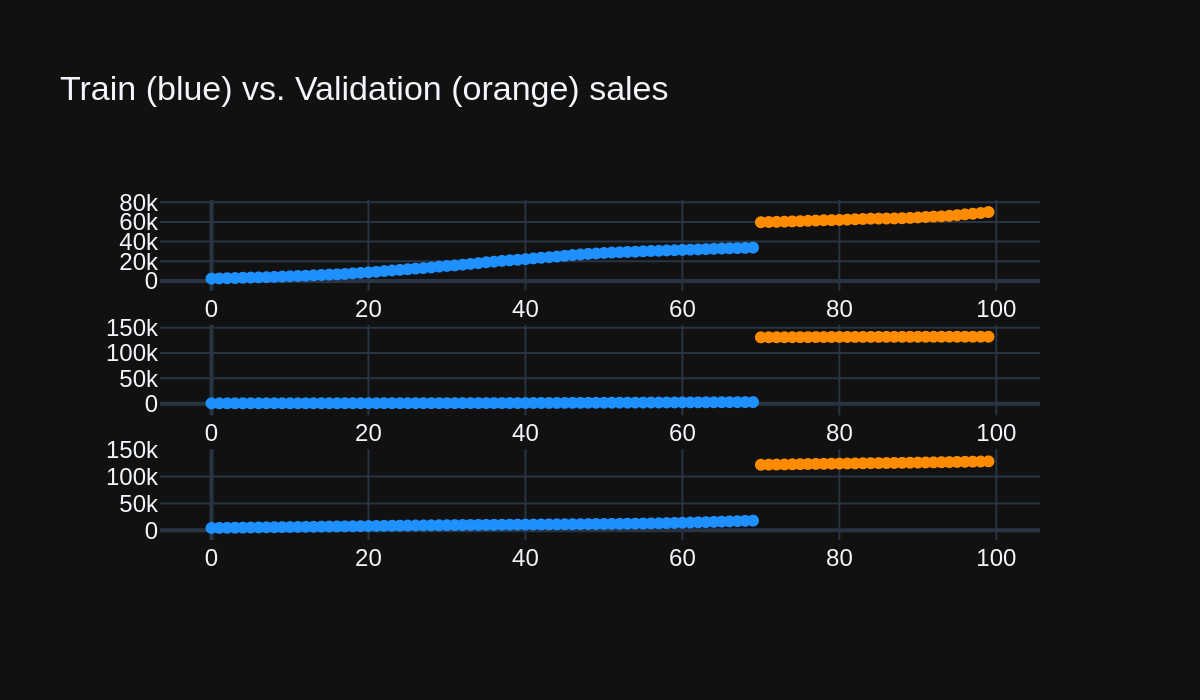

In [11]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))

## Naive approach <a id="3.2"></a>


The first approach is the very simple **naive approach**. It simply forecasts the next day's sales as the current day's sales. The model can be summarized as:

<img src="https://i.imgur.com/r8wjrzk.png" width="120px">

In the above equation, y<sub>t+1</sub> is the predicted value for the next day's sales and y<sub>t</sub> is today's sales. The model predicts tomorrow's sales as today's sales. Now let us see how this simple model performs on our miniature dataset. The training data is in <font color="blue">blue</font>, validation data in <font color="darkorange">orange</font>, and predictions in <font color="green">green</font>.

In [12]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(train_dataset[train_dataset.columns[-1]].values)
    else:
        predictions.append(val_dataset[val_dataset.columns[i-1]].values)
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_naive = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [13]:
error_naive

416.2269706675807

In [14]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Naive approach")
fig.show()

We can see that the forecasts made by the naive approach are not that accurate and it is to be expected of such a simple model. We need more complex models that use several time stamps to make forecasts.

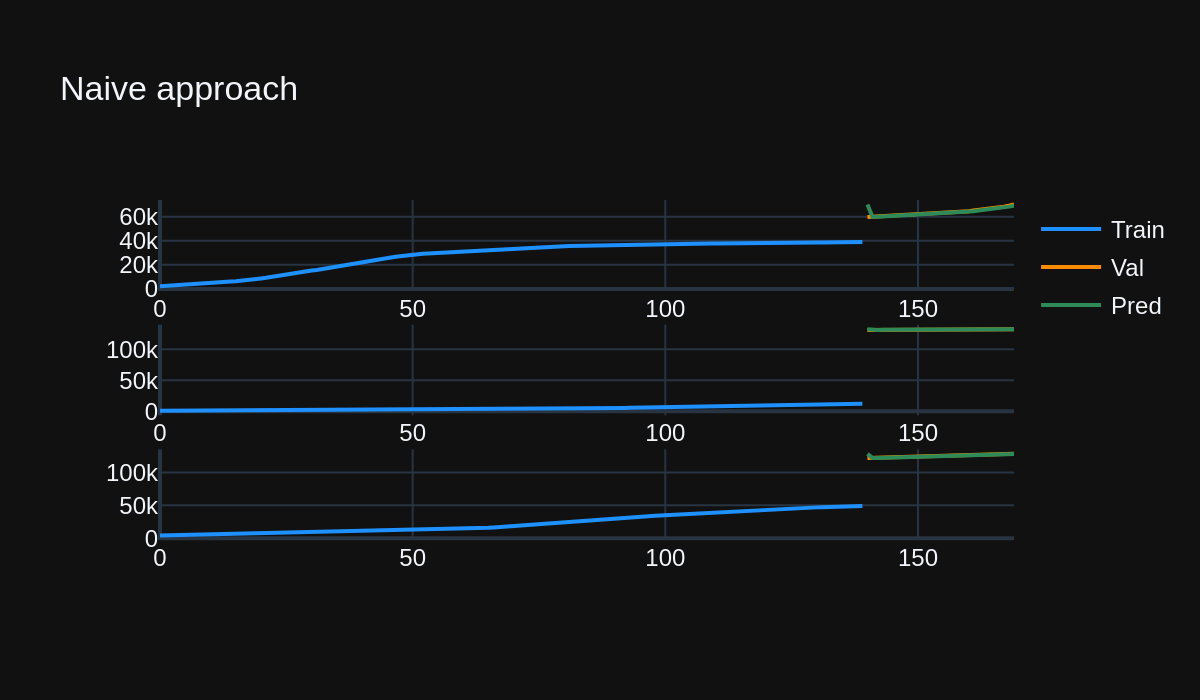

In [15]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))

## Moving average <a id="3.3"></a>

The **moving average** method is more complex than the naive approach. It calculates the mean sales over the previous 30 days and forecasts that as the next day's sales. This method takes the previous 30 timesteps into consideration, and is therefore less prone to short term fluctuations than the naive approach. The model can be summarized as:

<img src="https://i.imgur.com/5uJvt7H.png" width="220px">

In the above equation, y<sub>t+1</sub> is tomorrow's sales. On the right hand side, all the sales for the previous 30 days are added up and divided by 30 to find the average. This forms the model's prediction, y<sub>t+1</sub>. Now let us see how this new model performs on our miniature dataset. The training data is in <font color="blue">blue</font>, validation data in <font color="darkorange">orange</font>, and predictions in <font color="green">green</font>.

In [16]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(np.mean(train_dataset[train_dataset.columns[-30:]].values, axis=1))
    if i < 31 and i > 0:
        predictions.append(0.5 * (np.mean(train_dataset[train_dataset.columns[-30+i:]].values, axis=1) + \
                                  np.mean(predictions[:i], axis=0)))
    if i > 31:
        predictions.append(np.mean([predictions[:i]], axis=1))
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_avg = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [17]:
error_avg

508.54310260881226

In [18]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Moving average")
fig.show()

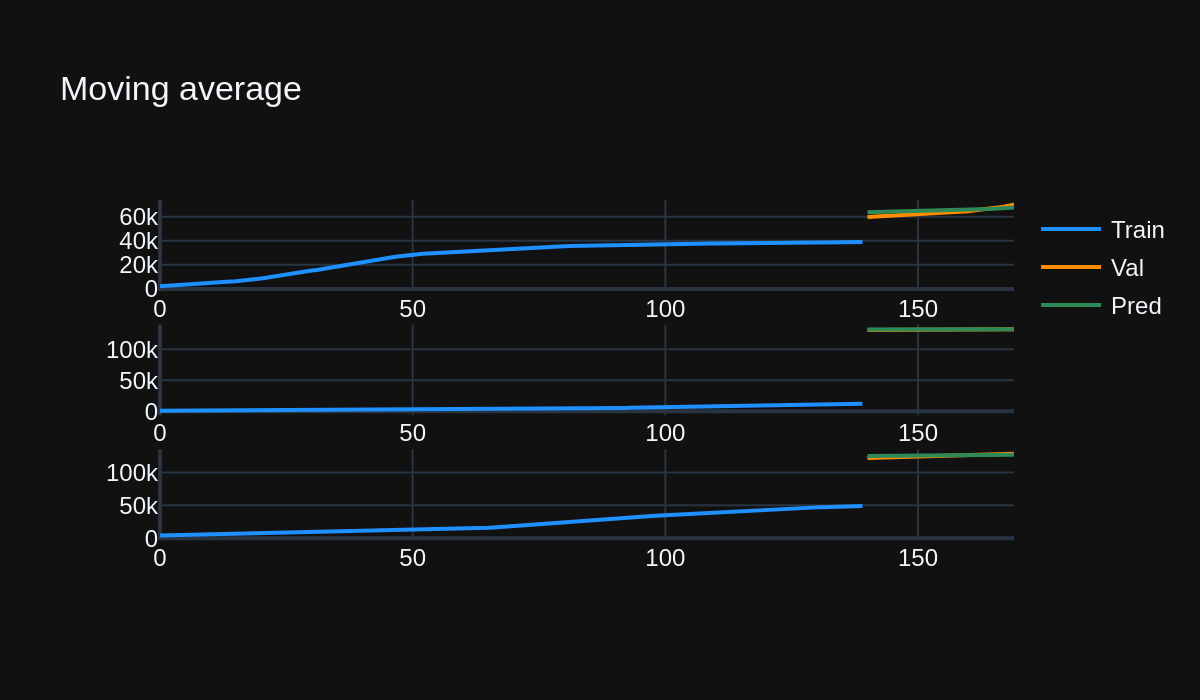

In [19]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))

## Holt linear <a id="3.4"></a>

The **Holt linear** is completely different from the first two methods. Holt linear attempts to capture the high-level trends in the time series data and fits the data with a straight line. The method can be summarized as follows:

### Forecast, level, and trend equations respectively

<img src="https://i.imgur.com/MHgcgGo.png" width="180px">
<img src="https://i.imgur.com/3ImRHEO.png" width="300px">
<img src="https://i.imgur.com/XExnvMX.png" width="300px">


In the above equations, $\alpha$ and $\beta$ are constants which can be configured. The values *l<sub>t</sub>* and *b<sub>t</sub>* represent the **level** and **trend** values repsectively. The trend value is the slope of the linear forecast function and the level value is the *y*-intercept of the linear forecast function. The slope and *y*-intercept values are continuously updated using the second and third update equations. Finally, the slope and *y*-intercept are used to calculate the forecast *y<sub>t+h</sub>* (in equation 1), which is *h* time steps ahead of the current time step. Now let us see how this model performs on our miniature dataset. The training data is in <font color="blue">blue</font>, validation data in <font color="darkorange">orange</font>, and predictions in <font color="green">green</font>.

In [20]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
    fit = Holt(row).fit(smoothing_level = 0.3, smoothing_slope = 0.01)
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_holt = np.linalg.norm(predictions - val_dataset.values[:len(predictions)])/len(predictions[0])

  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
error_holt

2297.5304839579826

In [22]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Holt linear")
fig.show()

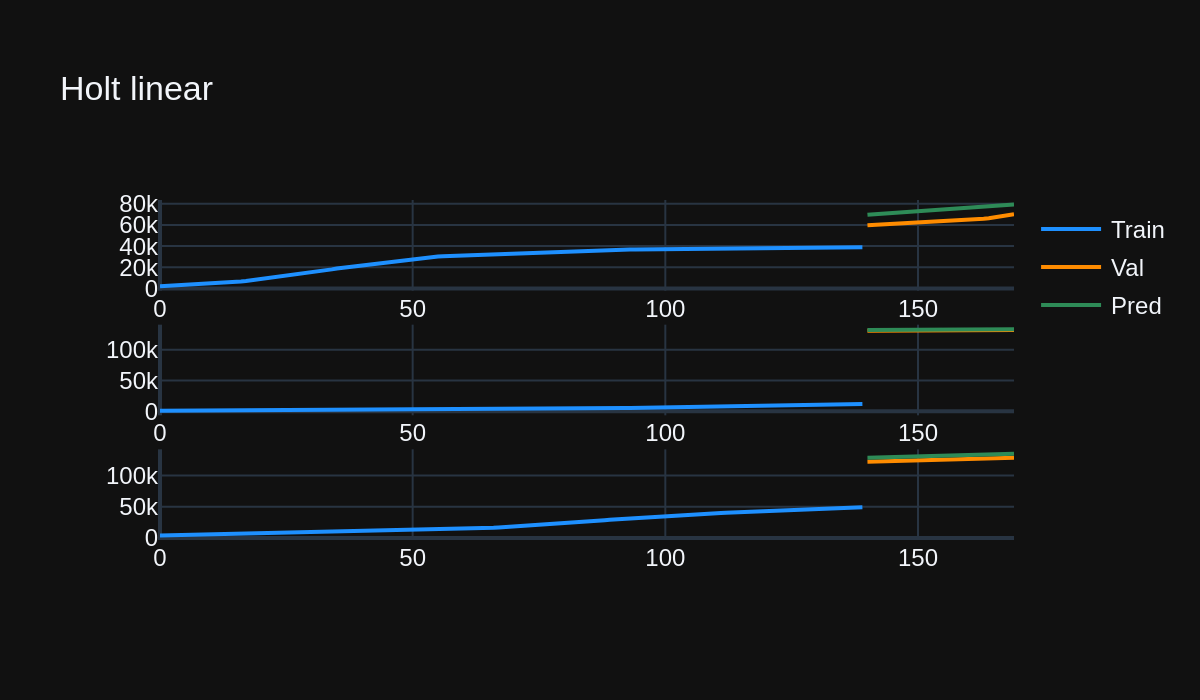

In [23]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))

## Exponential smoothing <a id="3.5"></a>

The **exponential smoothing** method uses a different type of "smoothing" which differs from average smoothing. The previous time steps are exponentially weighted and added up to generate the forecast. The weights decay as we move further backwards in time. The model can be summarized as follows:

<img src="https://i.imgur.com/IqqjOFc.png" width="520px">
<img src="https://i.imgur.com/GiyHyZf.png" width="255px">

In the above equations, $\alpha$ is the smoothing parameter. The forecast *y<sub>t+1</sub>* is a weighted average of all the observations in the series *y<sub>1</sub>, … ,y<sub>t</sub>*. The rate at which the weights decay is controlled by the parameter α. This method gives different weightage to different time steps, instead of giving the same weightage to all time steps (like the moving average method). This ensures that recent sales data is given more importance than old sales data while making the forecast. Now let us see how this new smoothing method performs on our miniature dataset. The training data is in <font color="blue">blue</font>, validation data in <font color="darkorange">orange</font>, and predictions in <font color="green">green</font>.

In [24]:
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
    fit = ExponentialSmoothing(row, seasonal_periods=3).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_exponential = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
error_exponential

1462.0287306414107

In [26]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Exponential smoothing")
fig.show()

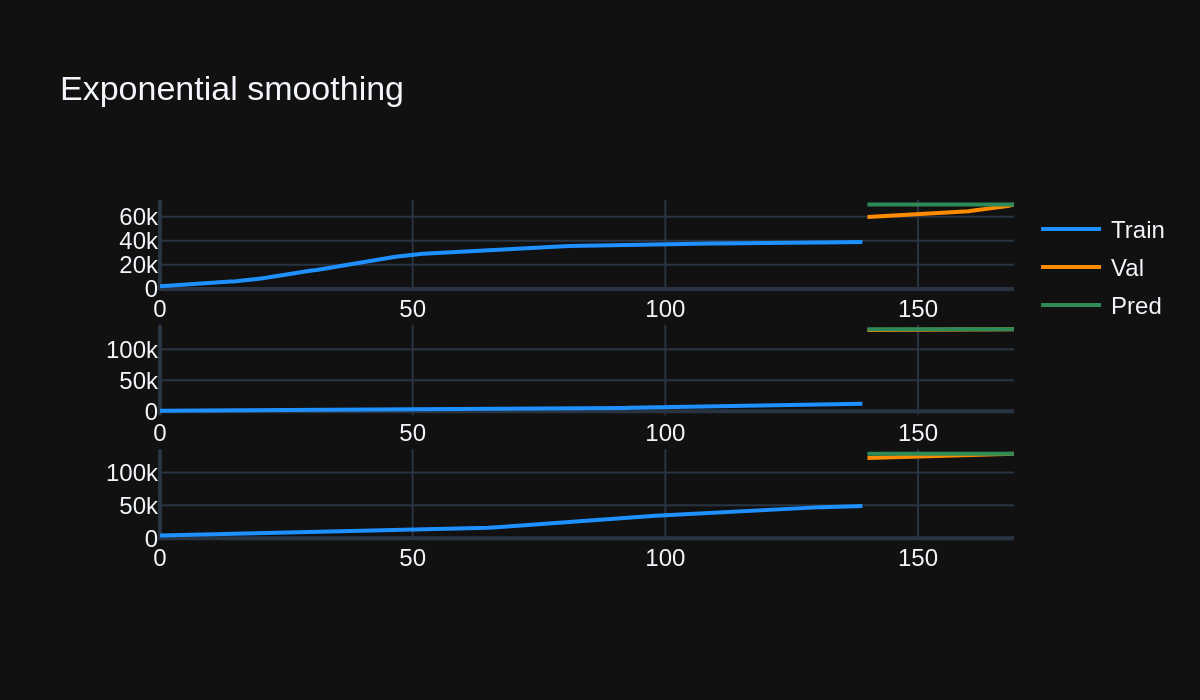

In [27]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))

## ARIMA <a id="3.6"></a>

Autoregressive integrated moving average (ARIMA) models were popularised by Box and Jenkins (1970). An ARIMA model describes a univariate time series as a combination of autoregressive (AR) and moving average (MA) lags which capture the autocorrelation within the time series. The order of integration denotes how many times the series has been differenced to obtain a stationary series.

We write an ARIMA(p,d,q) model for some time series data yt, where p is the number of autoregressive lags, d is the degree of differencing and q is the number of moving average lags as:

![](https://www.machinelearningplus.com/wp-content/uploads/2019/02/Equation-3-min.png)

ARIMA models are associated with a Box-Jenkins approach to time series. According to this approach, you should difference the series until it is stationary, and then use information criteria and autocorrelation plots to choose the appropriate lag order for an ARIMA process. You then apply inference to obtain latent variable estimates, and check the model to see whether the model has captured the autocorrelation in the time series. For example, you can plot the autocorrelation of the model residuals. Once you are happy, you can use the model for retrospection and forecasting.

In [28]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
    fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(0, 1, 1, 7)).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_arima = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
error_arima

1105.372440255941

In [30]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="ARIMA")
fig.show()

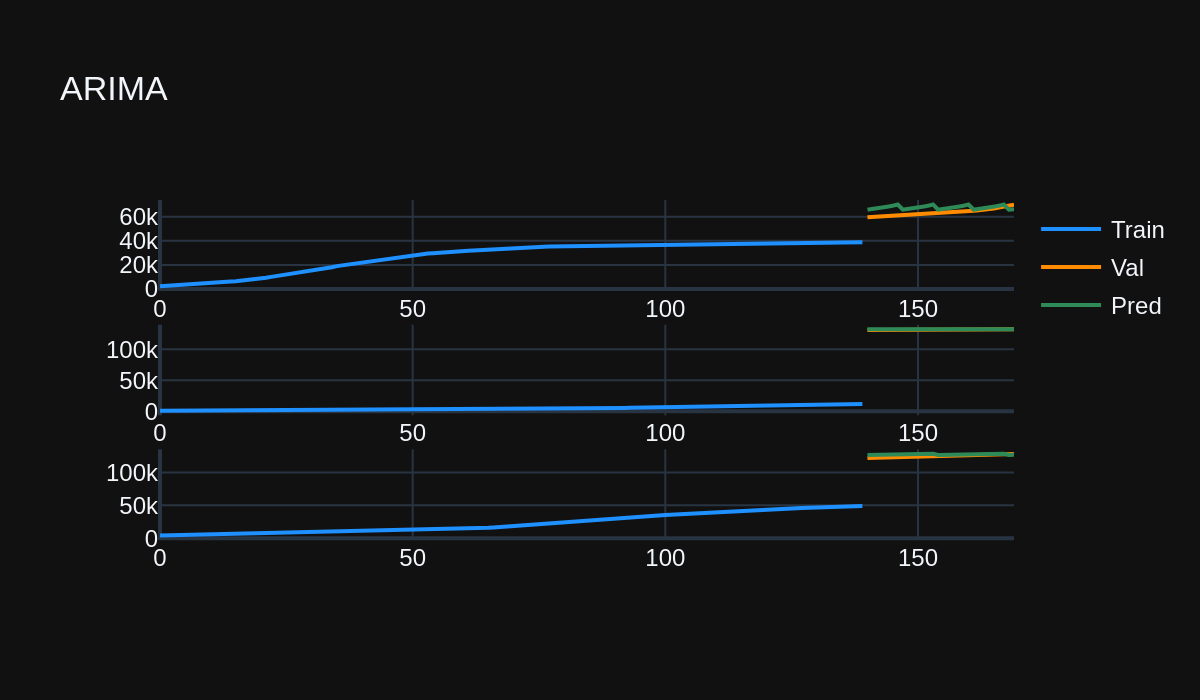

In [31]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))

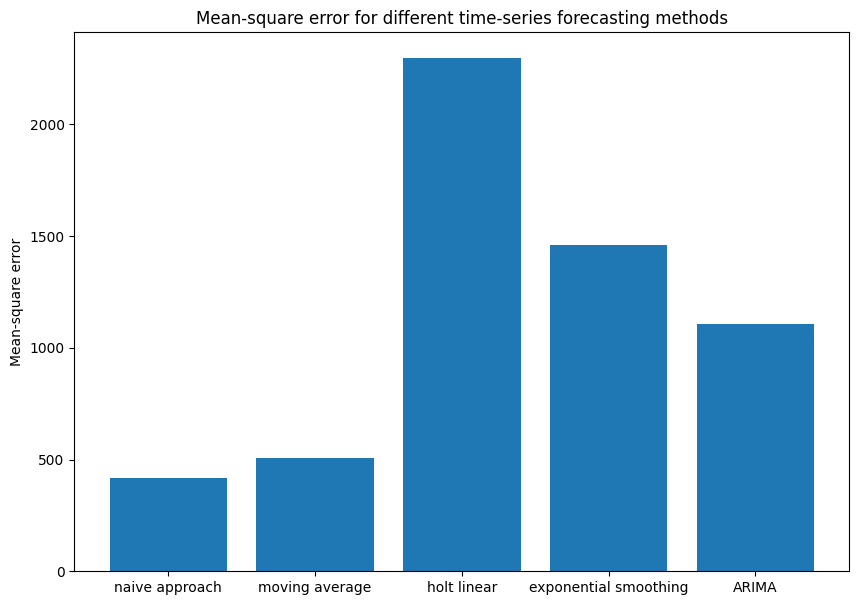

In [32]:
errors = [error_naive, error_avg, error_holt, error_exponential, error_arima]
methods = ['naive approach', 'moving average', 'holt linear', 'exponential smoothing', 'ARIMA']
fig, ax = plt.subplots(figsize=(10,7))
x_pos = np.arange(len(methods))
ax.bar(x_pos, errors)
ax.set_xticks(x_pos)
ax.set_xticklabels(methods)
ax.set_ylabel('Mean-square error')
ax.set_title('Mean-square error for different time-series forecasting methods')
plt.show()

# time_series_covid_19_deaths

lets see sample data first to make the visual of the predictions better 

In [33]:
train_dataset = pd.read_csv('/content/drive/MyDrive/covid_2/time_series_covid_19_deaths.csv')
drop_clo = ['Province/State','Country/Region','Lat','Long']
train_dataset=train_dataset.drop(drop_clo,axis=1)
datewise= list(train_dataset.columns)
val_dataset = train_dataset[datewise[-30:]]

In [34]:
train_dataset.drop(columns = train_dataset.columns[:100], axis = 1, inplace = True)
train_dataset

,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,68,72,85,90,95,104,106,109,115,120,...,2772,2782,2792,2802,2812,2836,2855,2869,2881,2899
1,31,31,31,31,31,31,31,31,31,31,...,2440,2441,2442,2444,2445,2447,2447,2447,2448,2449
2,453,459,463,465,470,476,483,488,494,502,...,3401,3405,3411,3418,3426,3433,3440,3448,3455,3460
3,43,44,45,45,46,46,47,47,48,48,...,127,127,127,127,127,127,127,127,127,127
4,2,2,2,2,2,2,2,2,2,2,...,704,709,715,725,731,735,742,745,749,757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0,0,0,0,0,0,0,0,0,0,...,39,41,42,43,44,44,45,46,47,47
272,2,2,2,2,2,2,2,2,2,2,...,3448,3452,3459,3459,3470,3480,3483,3483,3489,3492
273,2,2,2,2,3,5,5,5,7,8,...,1301,1302,1304,1307,1310,1311,1313,1315,1316,1319
274,3,3,3,3,3,4,4,4,7,7,...,1265,1266,1267,1268,1271,1271,1273,1275,1275,1276


In [35]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines+markers', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"), showlegend=False,),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[0].values, mode='lines+markers', marker=dict(color="darkorange"), showlegend=False,),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines+markers', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[1].values, mode='lines+markers', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines+markers', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[2].values, mode='lines+markers', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

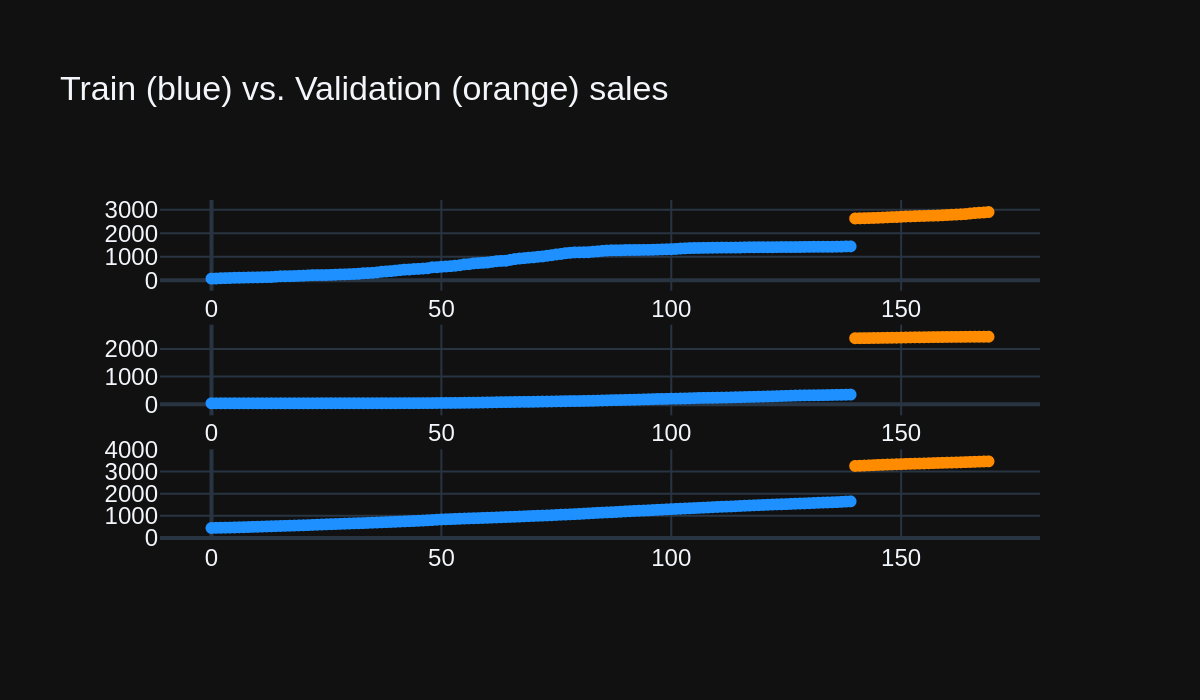

In [36]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))

## Naive approach <a id="3.2"></a>:

In [37]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(train_dataset[train_dataset.columns[-1]].values)
    else:
        predictions.append(val_dataset[val_dataset.columns[i-1]].values)
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_naive = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [38]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Naive approach")
fig.show()

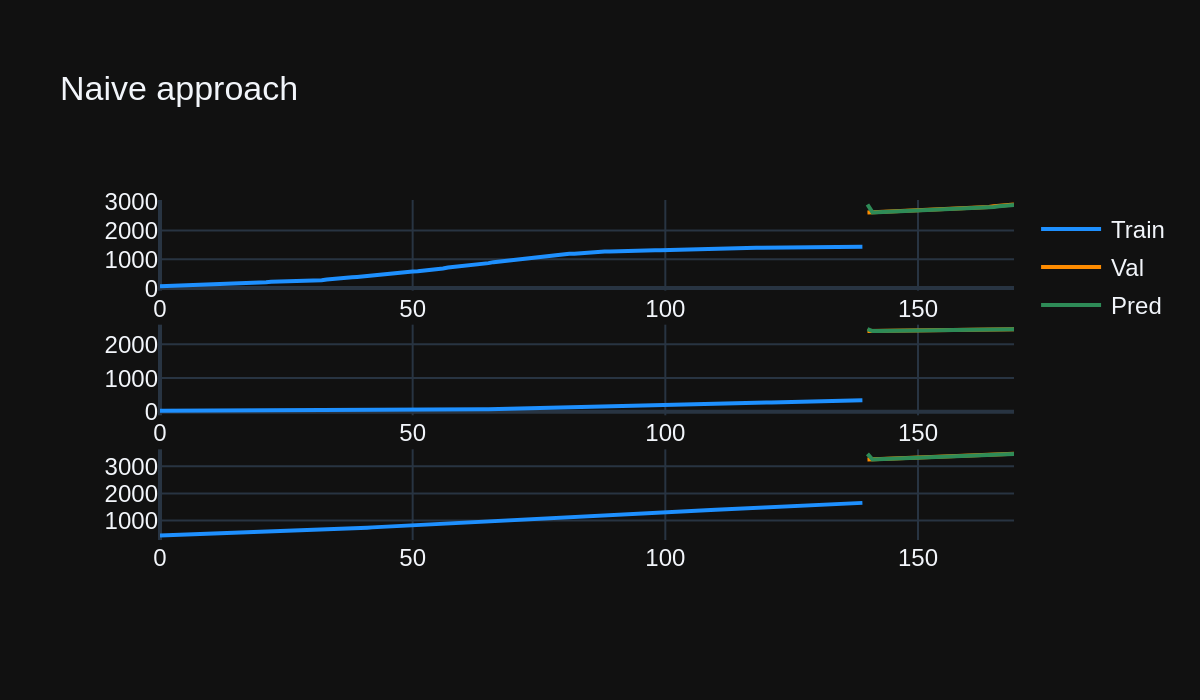

In [39]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))

## Moving average <a id="3.3"></a>:

In [40]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(np.mean(train_dataset[train_dataset.columns[-30:]].values, axis=1))
    if i < 31 and i > 0:
        predictions.append(0.5 * (np.mean(train_dataset[train_dataset.columns[-30+i:]].values, axis=1) + \
                                  np.mean(predictions[:i], axis=0)))
    if i > 31:
        predictions.append(np.mean([predictions[:i]], axis=1))
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_avg = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [41]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Moving average")
fig.show()

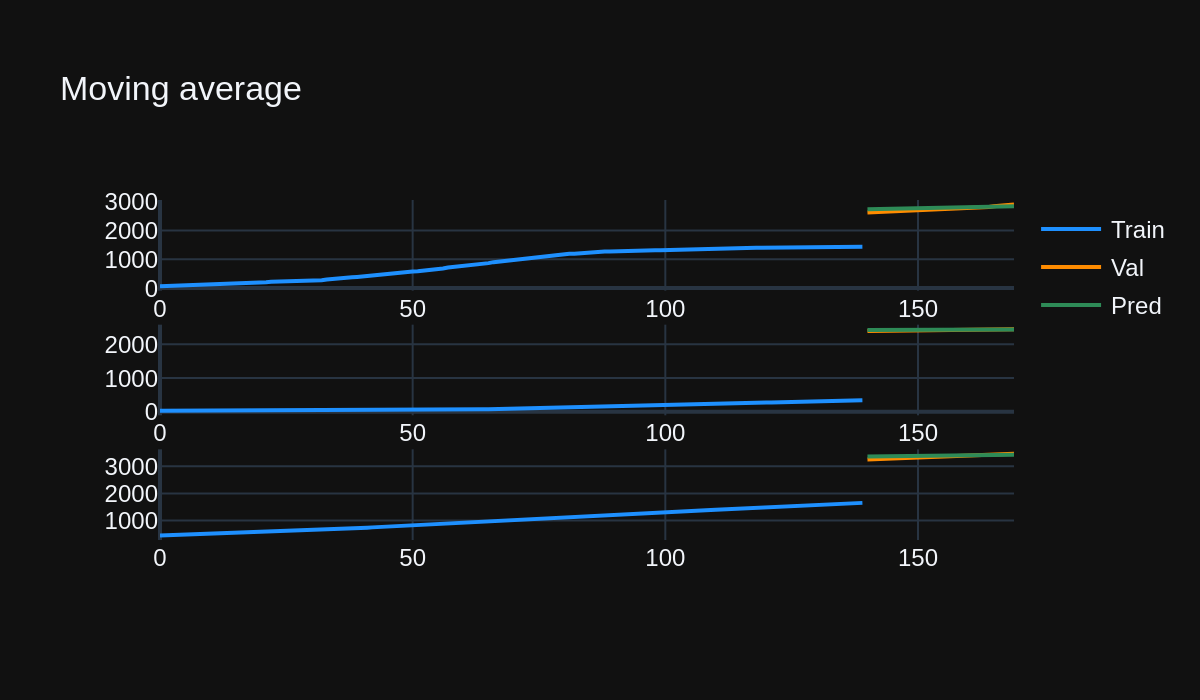

In [42]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))

# time_series_covid_19_recovered

lets see sample data first to make the visual of the predictions better 

In [43]:
train_dataset = pd.read_csv('/content/drive/MyDrive/covid_2/time_series_covid_19_recovered.csv')
drop_clo = ['Province/State','Country/Region','Lat','Long']
train_dataset=train_dataset.drop(drop_clo,axis=1)
datewise= list(train_dataset.columns)
val_dataset = train_dataset[datewise[-30:]]

In [44]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines+markers', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"), showlegend=False,),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[0].values, mode='lines+markers', marker=dict(color="darkorange"), showlegend=False,),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines+markers', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[1].values, mode='lines+markers', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines+markers', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[2].values, mode='lines+markers', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

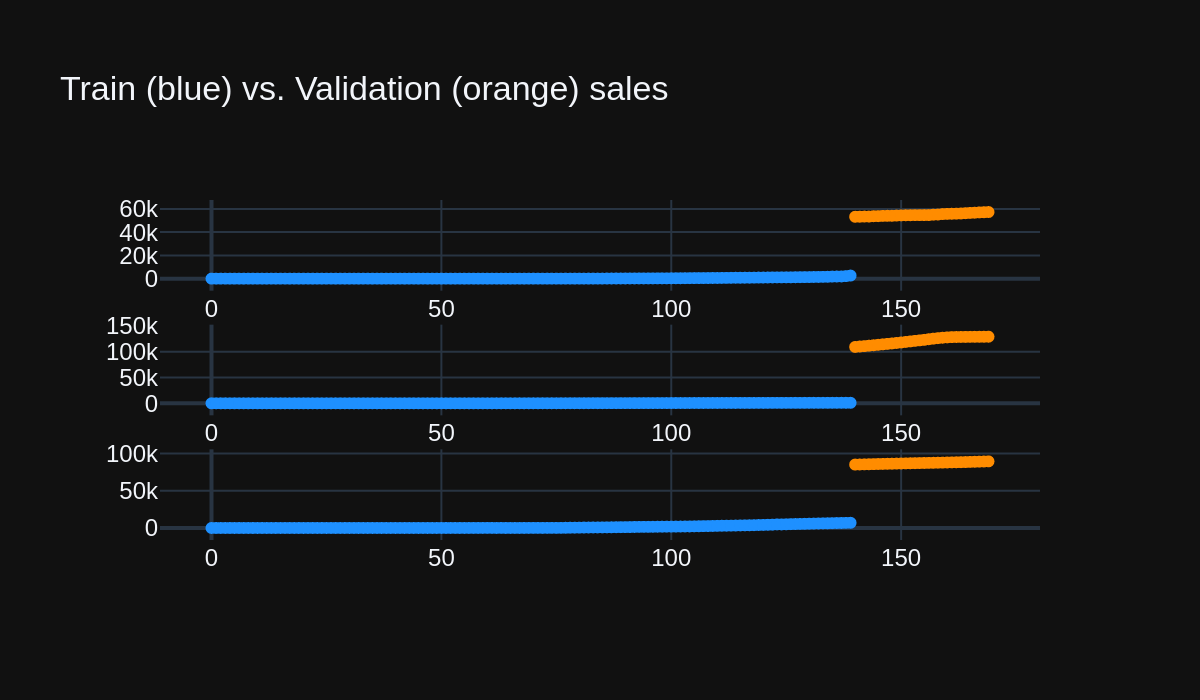

In [45]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))

In [46]:
train_dataset.drop(columns = train_dataset.columns[:100], axis = 1, inplace = True)
train_dataset

,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,310,331,345,397,421,458,468,472,502,558,...,55687,55790,55889,56035,56295,56518,56711,56962,57119,57281
1,488,519,531,543,570,595,605,620,627,650,...,127869,128425,128601,128732,128826,128907,128978,129042,129097,129215
2,1821,1872,1936,1998,2067,2197,2323,2467,2546,2678,...,87902,88066,88208,88346,88497,88672,88861,89040,89232,89419
3,468,472,493,499,514,521,526,537,545,550,...,13234,13234,13234,13234,13234,13263,13381,13405,13416,13416
4,11,11,11,11,11,11,11,11,13,13,...,26483,26513,26775,26778,27087,27204,27467,27529,27577,27646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,219,219,219,219,232,232,233,241,241,241,...,2687,2689,2721,2721,2794,2794,2853,2853,2896,2896
257,76,76,77,102,127,174,176,228,228,263,...,295643,296901,297201,297201,298502,299024,299559,299559,300125,300524
258,1,1,1,1,1,1,1,1,1,1,...,3159,3179,3201,3245,3260,3273,3306,3339,3375,3399
259,74,75,78,78,92,101,103,111,112,117,...,90955,91019,91102,91156,91200,91221,91239,91321,91443,91594


## Naive approach <a id="3.2"></a>:

In [47]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(train_dataset[train_dataset.columns[-1]].values)
    else:
        predictions.append(val_dataset[val_dataset.columns[i-1]].values)
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_naive = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [48]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Naive approach")
fig.show()

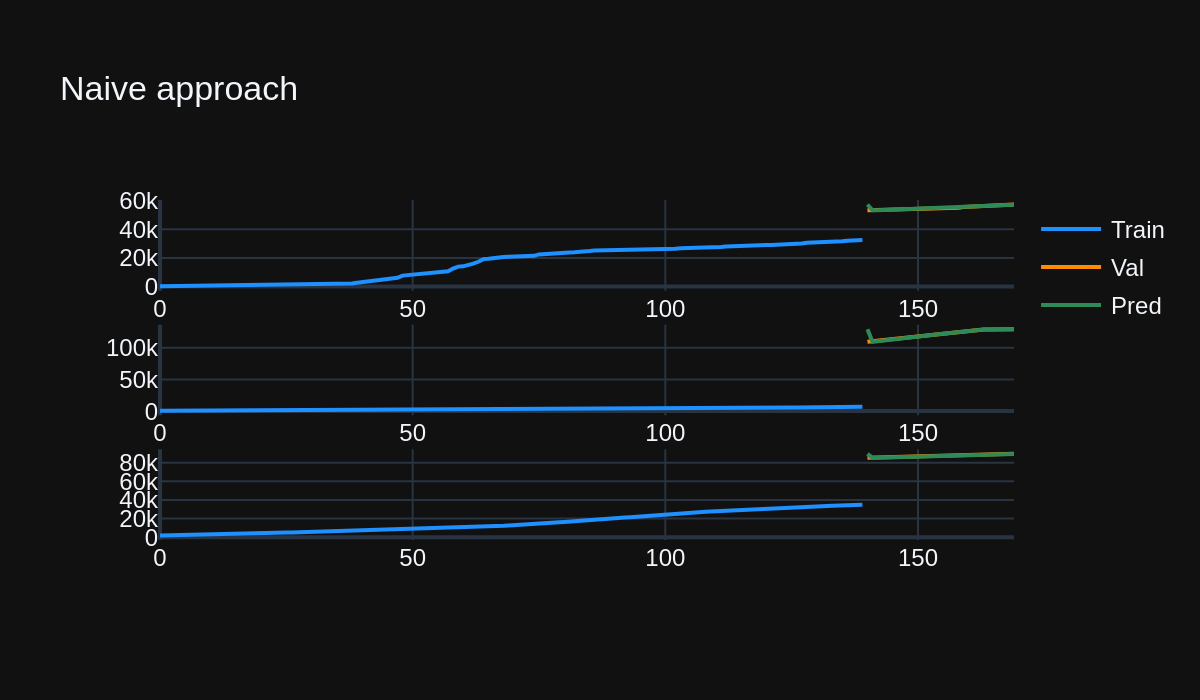

In [49]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))

## Moving average <a id="3.3"></a>:

In [50]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(np.mean(train_dataset[train_dataset.columns[-30:]].values, axis=1))
    if i < 31 and i > 0:
        predictions.append(0.5 * (np.mean(train_dataset[train_dataset.columns[-30+i:]].values, axis=1) + \
                                  np.mean(predictions[:i], axis=0)))
    if i > 31:
        predictions.append(np.mean([predictions[:i]], axis=1))
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_avg = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [51]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(140,200), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Moving average")
fig.show()

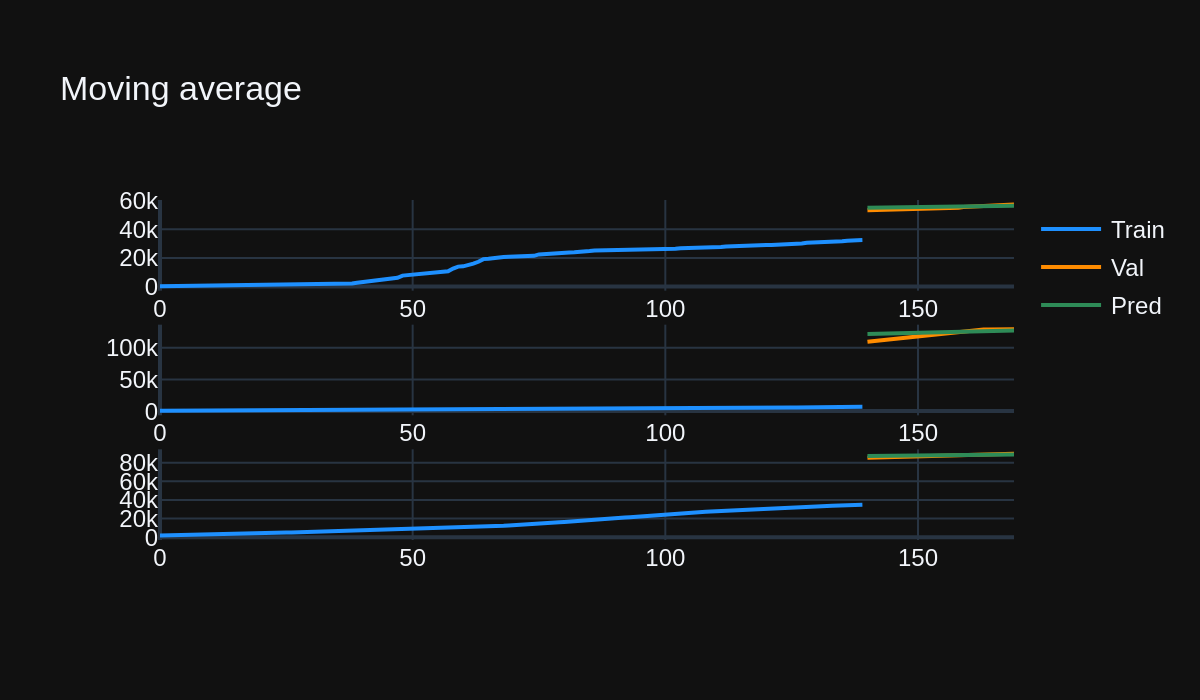

In [52]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))

## Comparison with similar Disease

In [53]:
full_latest_grouped = cleaned_data.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
epidemics = pd.DataFrame({
    'epidemic' : ['COVID-19', 'SARS', 'EBOLA', 'MERS', 'H1N1'],
    'start_year' : [2019, 2003, 2014, 2012, 2009],
    'end_year' : [2020, 2004, 2016, 2017, 2010],
    'confirmed' : [full_latest_grouped['Confirmed'].sum(), 8096, 28646, 2494, 6724149],
    'deaths' : [full_latest_grouped['Deaths'].sum(), 774, 11323, 858, 19654]
})

epidemics['mortality'] = round((epidemics['deaths']/epidemics['confirmed'])*100, 2)

epidemics.head()

,epidemic,start_year,end_year,confirmed,deaths,mortality
0,COVID-19,2019,2020,828508482,43384903,5.24
1,SARS,2003,2004,8096,774,9.56
2,EBOLA,2014,2016,28646,11323,39.53
3,MERS,2012,2017,2494,858,34.40
4,H1N1,2009,2010,6724149,19654,0.29


In [54]:
temp = epidemics.melt(id_vars='epidemic', value_vars=['confirmed', 'deaths', 'mortality'],
                      var_name='Case', value_name='Value')

fig = px.bar(temp, x="epidemic", y="Value", color='epidemic', text='Value', facet_col="Case",
             color_discrete_sequence = px.colors.qualitative.Bold)
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_yaxes(showticklabels=False)
fig.layout.yaxis2.update(matches=None)
fig.layout.yaxis3.update(matches=None)
fig.show()

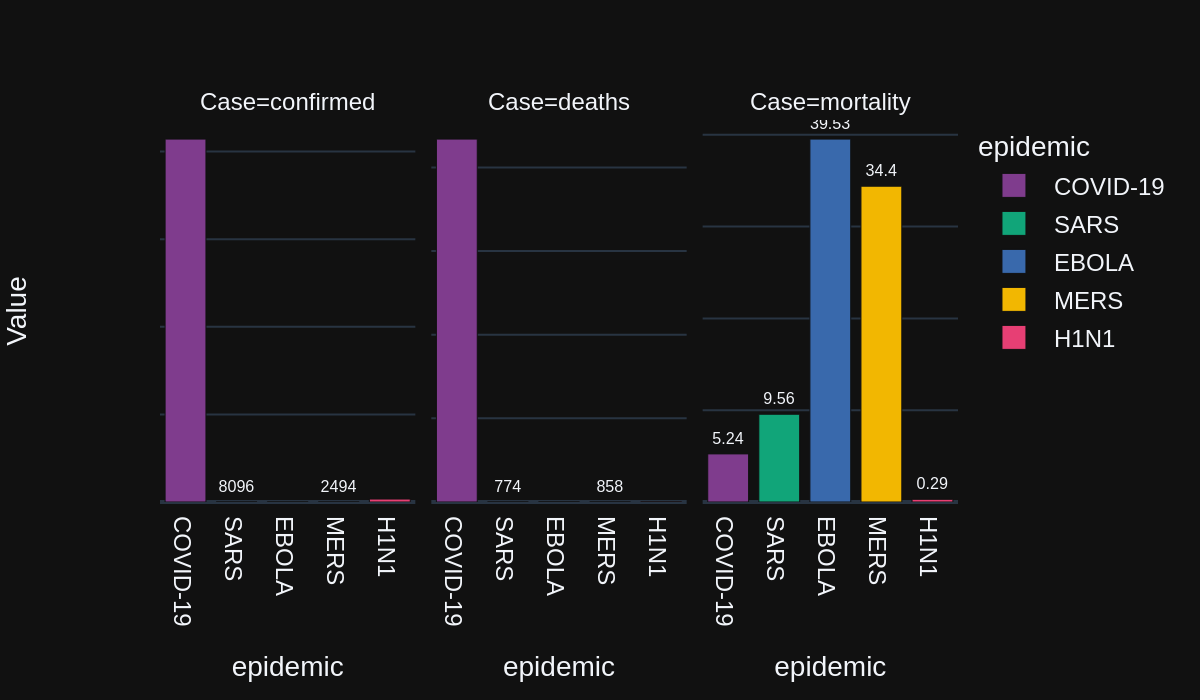

In [55]:
from IPython.display import Image
Image(fig.to_image(format="png", width=600, height=350, scale=2, engine="kaleido"))